/share/home/dynamo2/wangyu/.conda/envs/meteo_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'add_labels'
  result = super().contourf(*args, **kwargs)


Showing Topography Plot...


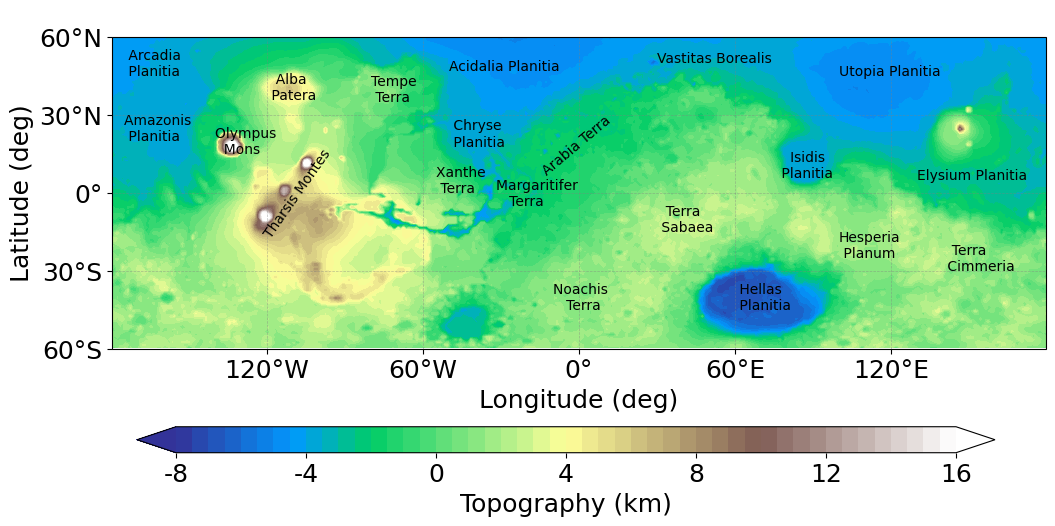

/share/home/dynamo2/wangyu/.conda/envs/meteo_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'add_labels'
  result = super().contourf(*args, **kwargs)


Showing Albedo Plot...


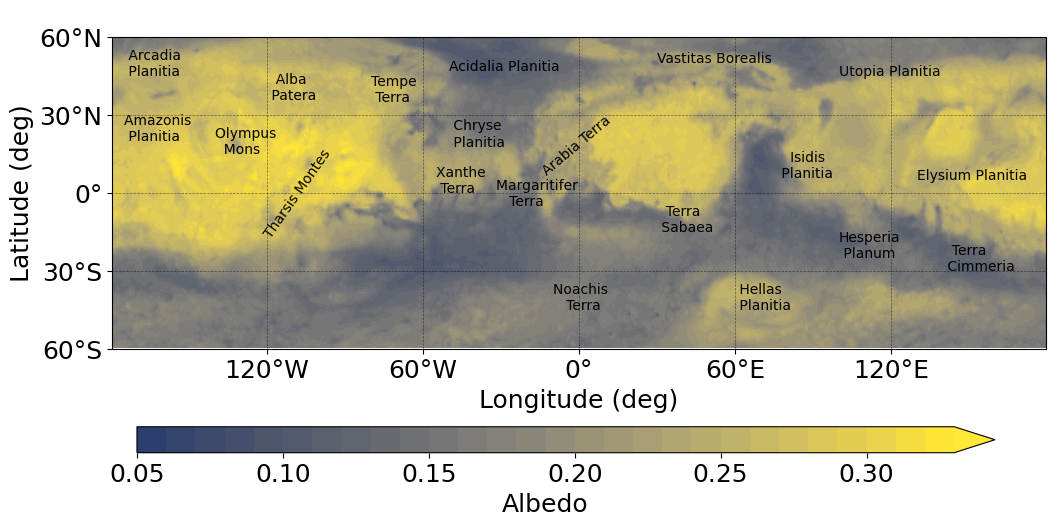

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FixedLocator

# ==========================================
# 1. Configuration & Data Loading
# ==========================================

# Define paths
FILE_TOPO = '../data/surface.nc'
FILE_ALB  = '../data/albedo.nc'

# Define bounds
LATS, LATN = -60., 60.
LONL, LONR = -180., 180.

def load_data():
    """Loads and preprocesses the datasets exactly as original code."""
    # Load Topography
    ds_z = xr.open_dataset(FILE_TOPO)
    z = ds_z['zMOL']
    
    # Load Albedo and process
    ds_alb = xr.open_dataset(FILE_ALB)
    alb = ds_alb['albedo']
    
    # Slice data to extents
    data_z = z.loc[LATN:LATS]
    data_alb = alb.loc[LATN:LATS]
    
    # Extract coordinates (using z for general lat/lon as they share the grid)
    lon = z['longitude'].loc[LONL:LONR]
    lat = z['latitude'].loc[LATN:LATS]
    
    # Extract specific coordinates for Albedo (in case of subtle grid differences after coarsen)
    lon_alb = alb['longitude'].loc[LONL:LONR]
    lat_alb = alb['latitude'].loc[LATN:LATS]
    
    return {
        'topo': {'data': data_z, 'lon': lon, 'lat': lat},
        'alb':  {'data': data_alb, 'lon': lon_alb, 'lat': lat_alb}
    }

# ==========================================
# 2. Visualization Functions
# ==========================================

def add_axes(fig, pos, lon, lat, title=''):
    ax = fig.add_axes(pos, projection=ccrs.PlateCarree(central_longitude=(LONL+LONR)/2))
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    
    ax.set_xticks(np.arange(LONL+60, LONR, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(LATS+0, LATN+1, 30), crs=ccrs.PlateCarree())
    
    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    # Tick params
    ax.tick_params('both', which='both', top=False, right=False, labelsize=18)
    ax.set_xlabel('Longitude (deg)', fontsize=18)
    ax.set_ylabel('Latitude (deg)', fontsize=18)
    
    ax.set_title(title, loc='center', fontdict={'fontsize': 18})
    return ax

def add_texts(ax):
    fs = 10
    
    # General locations
    terrs = [
        [' Chryse \n Planitia', '18', '-50',],
        ['Xanthe \n Terra', '0', '-55',],
        ['Margaritifer \n   Terra', '-5', '-32',],
        [' Hellas \n Planitia', '-45', '60',],
        ['   Isidis \n Planitia', '6', '76'],
        ['Elysium Planitia', '5', '130'],
        ['Olympus \n  Mons', '15', '-140'],
        ['Amazonis \n Planitia', '20', '-175'],
        ['Acidalia Planitia', '47', '-50'],
        [' Arcadia \n Planitia', '45', '-175'],
        ['  Terra \n Sabaea', '-15', '30'],
        ['Noachis \n   Terra', '-45', '-10'],
        ['Tempe \n Terra', '35', '-80'],
        ['Vastitas Borealis', '50', '30'],
        ['Utopia Planitia', '45', '100'],
        ['  Terra \n Cimmeria', '-30', '140'],
        ['Hesperia\n Planum', '-25', '100'],
        ['  Alba \n Patera', '36', '-120'],
    ]
    
    for terr in terrs:
        ax.text(float(terr[2]), float(terr[1]), terr[0], transform=ccrs.PlateCarree(), fontsize=fs, color='black')
        
    ax.text(-15, 7, 'Arabia Terra', transform=ccrs.PlateCarree(), fontsize=fs, color='black', rotation=40)
    ax.text(-122, -17, 'Tharsis Montes', transform=ccrs.PlateCarree(), fontsize=fs, color='black', rotation=55)
    return ax

def plot_map_panel(fig, lon, lat, data, config):
    """
    Generic plotting function to handle both Topography and Albedo.
    config: Dictionary containing specific settings (cmap, levels, labels, etc.)
    """
    
    # 1. Create Axes
    ax = add_axes(fig, [0.12, 0.70, 0.4, 0.12], lon, lat, ' ')
    
    # 2. Plot Contour
    contourf_kw = dict(
        transform=ccrs.PlateCarree(),
        levels=config['levels'],
        cmap=config['cmap'],
        add_colorbar=False,
        add_labels=False,
        vmin=config['vmin'],
        vmax=config['vmax'],
        extend=config['extend'],
        zorder=0
    )
    
    c1 = ax.contourf(lon, lat, data, **contourf_kw)
    
    # 3. Create Colorbar
    position = fig.add_axes([0.15, 0.66, 0.33, 0.010])
    cb = fig.colorbar(c1, cax=position, orientation='horizontal', format='%.1f')
    
    # Colorbar Ticks
    cb.ax.set_xticks(config['cbar_ticks'])
    cb.ax.set_xticks(config['cbar_ticks'], labels=config['cbar_labels'])
    cb.ax.set_xlabel(config['cbar_label'], fontsize=18)
    plt.setp(cb.ax.get_xticklabels(), fontsize=18)
    
    # 4. Gridlines
    gl = ax.gridlines(linewidth=0.5, color=config['grid_color'], alpha=0.5, linestyle='--')
    gl.xlocator = FixedLocator(np.arange(LONL+60, LONR, 60))
    gl.ylocator = FixedLocator(np.arange(LATS+0, LATN+1, 30))
    
    # 5. Add Text Annotations
    ax = add_texts(ax)

# ==========================================
# 3. Main Execution
# ==========================================

if __name__ == "__main__":
    # Load Data
    datasets = load_data()
    
    # --- Plot 1: Topography ---
    fig1 = plt.figure(figsize=(26, 26))
    
    topo_config = {
        'levels': np.arange(-8, 16.1, 0.5),
        'cmap': mpl.cm.terrain,
        'vmin': -8,
        'vmax': 16,
        'extend': 'both',
        'cbar_ticks': np.arange(-8, 17, 4),
        'cbar_labels': [f'{x:1.0f}' for x in np.arange(-8, 17, 4)],
        'cbar_label': 'Topography (km)',
        'grid_color': 'gray'
    }
    
    plot_map_panel(
        fig1, 
        datasets['topo']['lon'], 
        datasets['topo']['lat'], 
        datasets['topo']['data'], 
        topo_config
    )
    print("Showing Topography Plot...")
    plt.show()

    # --- Plot 2: Albedo ---
    fig2 = plt.figure(figsize=(26, 26))
    
    alb_config = {
        'levels': np.arange(0.05, 0.33, 0.01),
        'cmap': mpl.cm.cividis,
        'vmin': 0,
        'vmax': 0.33,
        'extend': 'max',
        'cbar_ticks': np.arange(0.05, 0.33, 0.05),
        'cbar_labels': [f'{x:1.2f}' for x in np.arange(0.05, 0.33, 0.05)],
        'cbar_label': 'Albedo',
        'grid_color': 'k'
    }
    
    plot_map_panel(
        fig2, 
        datasets['alb']['lon'], 
        datasets['alb']['lat'], 
        datasets['alb']['data'], 
        alb_config
    )
    print("Showing Albedo Plot...")
    plt.show()